In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np

## Read in Data

### Transaction

In [2]:
transaction = pd.read_csv("train_transaction.csv")
transaction_data = transaction.copy()


### Identity

In [3]:
identity = pd.read_csv("train_identity.csv")
identity_data = identity.copy()


### Function to inspect and analyze dataset

In [4]:
import pandas as pd
import numpy as np

def analyze_unknown_columns(df):
    """
    column analysis function translated from R
    """
    analysis_data = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        col_type = col_data.dtype
        na_percent = round(col_data.isna().mean() * 100, 2)
        unique_values = col_data.nunique()
        
        # Min/Max for numeric columns
        if np.issubdtype(col_type, np.number):
            if col_data.notna().any():
                min_val = round(col_data.min(), 2)
                max_val = round(col_data.max(), 2)
            else:
                min_val = "All NA"
                max_val = "All NA"
        else:
            min_val = "N/A"
            max_val = "N/A"
        
        # Sample values (first 5 non-null unique values)
        sample_vals = col_data.dropna().unique()[:5]
        sample_str = ", ".join(str(x) for x in sample_vals)
        
        analysis_data.append({
            'column': col,
            'type': col_type,
            'na_percent': na_percent,
            'unique_values': unique_values,
            'min_value': min_val,
            'max_value': max_val,
            'sample_values': sample_str
        })
    
    # Create analysis DataFrame
    column_analysis = pd.DataFrame(analysis_data)
    
    print("=== AUTOMATED COLUMN ANALYSIS ===")
    pd.set_option('display.max_rows', None)
    print(column_analysis)
    pd.reset_option('display.max_rows')
    
    return column_analysis



In [5]:
#check memory usage

memory_mb = transaction_data.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory: {memory_mb:.2f} MB")

Total memory: 2062.07 MB


In [6]:
#  analyze Usage
#column_info = analyze_unknown_columns(transaction_data)

### Handle Missing Data, impute for numeric columns

In [7]:
def handle_missing_columns(df, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=None):
    """
    Optimized version that avoids fragmentation by collecting all indicators first.

    
    Create missingness indicators for columns with NA fraction >= missing_threshold.
    Drop original columns if NA fraction >= drop_threshold.
    Impute mean for numeric columns that are kept.
    encode categorical columns

    Parameters:
        df: DataFrame
        missing_threshold: create indicators for columns with NA >= this fraction
        drop_threshold: drop original columns if NA >= this fraction
        exclude_cols: list of columns not to modify (e.g., target, ID)

    Returns:
        df_copy: cleaned DataFrame
        dropped_cols: list of original columns that were dropped
    """

    df = df.copy()  # protect original

    if exclude_cols is None:
        exclude_cols = []

    cols = [c for c in df.columns if c not in exclude_cols]
    dropped_cols = []
    
    # Step 1: Create missing indicators for ALL columns above missing_threshold
    cols_for_indicators = []
    for col in cols:
        na_frac = df[col].isna().mean()
        if na_frac >= missing_threshold:
            cols_for_indicators.append(col)
    
    # Create all indicators at once
    if cols_for_indicators:
        missing_indicators = {}
        for col in cols_for_indicators:
            missing_indicators[f"{col}_missing"] = df[col].isna().astype(np.int8)
        
        indicators_df = pd.DataFrame(missing_indicators, index=df.index)
        df = pd.concat([df, indicators_df], axis=1)

    # Step 2: Now drop columns above drop_threshold
    cols_to_drop = []
    for col in cols:
        na_frac = df[col].isna().mean()
        if na_frac >= drop_threshold:
            cols_to_drop.append(col)
    
    df.drop(columns=cols_to_drop, inplace=True)
    dropped_cols = cols_to_drop.copy()
        
    
    # Step 3: Impute numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [c for c in numeric_cols if not c.endswith("_missing")]
    
    for col in numeric_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mean())

    # Step 4: Handle categorical columns using tree-friendly preprocessing
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Binary columns (2 unique values, excluding NaN)
    binary_cols = [c for c in cat_cols if df[c].nunique(dropna=True) == 2]
    # Small multi-category columns (3–10 unique values)
    small_cat_cols = [c for c in cat_cols if 3 <= df[c].nunique(dropna=True) <= 10]
    # High-cardinality columns (>10 unique values)
    high_card_cols = [c for c in cat_cols if df[c].nunique(dropna=True) > 10]

    # --- Binary columns ---
    for col in binary_cols:
        vals = df[col].dropna().unique()
        mapping = {vals[0]: 0, vals[1]: 1}
        # Simply map and fill missing with -1
        df[col] = df[col].map(mapping).fillna(-1)

    # --- Small multi-category columns ---
    if small_cat_cols:
        df = pd.get_dummies(df, columns=small_cat_cols, dummy_na=True, drop_first=False)

    # --- High-cardinality columns ---
    for col in high_card_cols:
        freq = df[col].value_counts(dropna=False)
        df[col + "_freq"] = df[col].map(freq)
        df.drop(columns=[col], inplace=True)
    
    return df, dropped_cols

In [8]:
exclude = ["TransactionID", "isFraud"]

train_transaction_clean, dropped_cols = handle_missing_columns(
    transaction_data, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=exclude
)

print("Dropped columns:", dropped_cols)

Dropped columns: ['dist2', 'D7']


In [9]:
#check memory usage

memory_mb = train_transaction_clean.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory: {memory_mb:.2f} MB")

Total memory: 1878.78 MB


In [14]:
#  analyze Usage
column_info = analyze_unknown_columns(train_transaction_clean)

=== AUTOMATED COLUMN ANALYSIS ===
                     column     type  na_percent  unique_values min_value  \
0             TransactionID    int64         0.0         590540   2987000   
1                   isFraud    int64         0.0              2         0   
2             TransactionDT    int64         0.0         573349     86400   
3            TransactionAmt  float64         0.0          20902      0.25   
4                     card1    int64         0.0          13553      1000   
5                     card2  float64         0.0            501     100.0   
6                     card3  float64         0.0            115     100.0   
7                     card5  float64         0.0            120     100.0   
8                     addr1  float64         0.0            333     100.0   
9                     addr2  float64         0.0             75      10.0   
10                    dist1  float64         0.0           2652       0.0   
11                       C1  float64      

In [10]:
exclude = ["TransactionID", "isFraud"]

train_identity_clean, dropped_cols = handle_missing_columns(
    identity_data, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=exclude
)

In [12]:
## List of Matching TransactionIDs
merged_df_left = pd.merge(train_identity_clean, train_transaction_clean, on='TransactionID', how='left')
merged_df_inner = pd.merge(train_identity_clean, train_transaction_clean, on='TransactionID', how='inner')


overlapping_ids = train_identity_clean['TransactionID'].tolist()


#Random forest


In [13]:
## Fraud Detection with Random Forest

# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# Assuming train_transaction_clean is already prpard for RF
data = train_transaction_clean.copy()

X = data.drop(columns=["isFraud"])
y = data["isFraud"]

## split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7406
)

# %%
### Identity data integration (using your cleaned data)
# Using your merged DataFrames
merged_df_inner = pd.merge(train_identity_clean, train_transaction_clean, on='TransactionID', how='inner')

X_combined = merged_df_inner.drop(columns=["isFraud"])
y_combined = merged_df_inner["isFraud"]

## subset split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=7406
)

# %%
### Transaction data subset
overlapping_ids = train_identity_clean['TransactionID'].tolist()

transaction_subset = train_transaction_clean[train_transaction_clean['TransactionID'].isin(overlapping_ids)]

X_subset = transaction_subset.drop(columns=["isFraud"])
y_subset = transaction_subset["isFraud"]

## subset split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=7406
)



In [15]:
# ## Random Forest Modeling function

# %%
### Random Forest
def RandomForest(X_train, X_test, y_train, y_test):
    
    # Handle categorical columns - RF needs encoding
    object_columns = X_train.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        print(f"Encoding {len(object_columns)} categorical columns for Random Forest")
        # Simple label encoding for categorical columns
        for col in object_columns:
            X_train[col] = X_train[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes
    
    # Random Forest parameters optimized for fraud detection
    rf_model = RandomForestClassifier(
        n_estimators=100,           # Number of trees
        max_depth=15,               # Control tree depth to prevent overfitting
        min_samples_split=50,       # Minimum samples to split
        min_samples_leaf=20,        # Minimum samples per leaf
        max_features='sqrt',        # Feature sampling
        class_weight='balanced',    # Handle imbalanced data
        random_state=7406,
        n_jobs=-1                  # Use all cores
    )
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predict probabilities
    pred_rf = rf_model.predict_proba(X_test)[:, 1]
    pr_auc_rf = average_precision_score(y_test, pred_rf)
    
    return pr_auc_rf, rf_model


In [19]:
## Random Forest Modeling function with Quick Tuning

# %%
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

def quick_rf_tuning(X_train, y_train, n_iter=10, sample_frac=0.2):
    """
    Quick parameter tuning using randomized search on a sample
    """
    # Sample data for faster tuning
    X_sample = X_train.sample(frac=sample_frac, random_state=7406)
    y_sample = y_train.loc[X_sample.index]
    
    print(f"Quick tuning on {len(X_sample):,} samples ({sample_frac*100}% of data)")
    
    # Parameter distributions for fraud detection
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': randint(20, 100),
        'min_samples_leaf': randint(10, 50),
        'max_features': ['sqrt', 'log2', 0.3, 0.5],
        'class_weight': ['balanced', 'balanced_subsample']
    }
    
    rf = RandomForestClassifier(random_state=7406, n_jobs=-1)
    
    # Quick randomized search
    random_search = RandomizedSearchCV(
        rf, param_dist, 
        n_iter=n_iter,
        scoring='average_precision',  # PR AUC for fraud detection
        cv=3,  # Fewer folds for speed
        random_state=7406,
        n_jobs=1,  # Single job to avoid memory issues
        verbose=0
    )
    
    random_search.fit(X_sample, y_sample)
    
    print(f"Best PR AUC from tuning: {random_search.best_score_:.4f}")
    print("Best parameters:", random_search.best_params_)
    
    return random_search.best_params_


In [20]:

def data_driven_rf_params(X_train, y_train):
    """
    Choose parameters based on dataset characteristics
    """
    n_samples, n_features = X_train.shape
    
    # Base parameters
    params = {
        'random_state': 7406,
        'n_jobs': -1,
        'class_weight': 'balanced'
    }
    
    # Adjust based on dataset size and features
    if n_samples > 500000:  # Very large dataset
        params.update({
            'n_estimators': 100,
            'max_depth': 20,
            'min_samples_split': 100,
            'min_samples_leaf': 30,
            'max_features': 0.3  # More aggressive feature sampling
        })
    elif n_samples > 100000:  # Large dataset
        params.update({
            'n_estimators': 150,
            'max_depth': 15,
            'min_samples_split': 50,
            'min_samples_leaf': 20,
            'max_features': 'sqrt'
        })
    else:  # Medium/small dataset
        params.update({
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 20,
            'min_samples_leaf': 10,
            'max_features': 'sqrt'
        })
    
    return params


In [21]:


def RandomForest(X_train, X_test, y_train, y_test, tune_params=True, tuning_sample_frac=0.1):
    """
    Enhanced Random Forest with optional quick parameter tuning
    
    Parameters:
    - tune_params: Whether to perform quick parameter tuning
    - tuning_sample_frac: Fraction of data to use for tuning (0.1 = 10%)
    """
    
    # Handle categorical columns - RF needs encoding
    object_columns = X_train.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        print(f"Encoding {len(object_columns)} categorical columns for Random Forest")
        # Simple label encoding for categorical columns
        for col in object_columns:
            X_train[col] = X_train[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes
    
    # Choose parameters
    if tune_params:
        print("Performing quick parameter tuning...")
        try:
            # Quick tuning on small sample
            best_params = quick_rf_tuning(X_train, y_train, n_iter=8, sample_frac=tuning_sample_frac)
            rf_params = best_params
            rf_params['random_state'] = 7406
            rf_params['n_jobs'] = -1
            print("Using tuned parameters")
        except Exception as e:
            print(f"Tuning failed, using data-driven parameters. Error: {e}")
            rf_params = data_driven_rf_params(X_train, y_train)
            print("Using data-driven parameters")
    else:
        rf_params = data_driven_rf_params(X_train, y_train)
        print("Using data-driven parameters without tuning")
    
    print(f"Final RF parameters: {rf_params}")
    
    # Random Forest model
    rf_model = RandomForestClassifier(**rf_params)
    
    # Train the model with progress tracking for large datasets
    print(f"Training Random Forest on {len(X_train):,} samples...")
    rf_model.fit(X_train, y_train)
    
    # Predict probabilities
    pred_rf = rf_model.predict_proba(X_test)[:, 1]
    pr_auc_rf = average_precision_score(y_test, pred_rf)
    
    return pr_auc_rf, rf_model, rf_params


In [25]:

#transaction data only
rf_transaction, model_full, params_full = RandomForest(X_train, X_test, y_train, y_test)
print(f"Random Forest PR AUC for Full Transaction Data: {rf_transaction:.4f}")



Performing quick parameter tuning...
Quick tuning on 47,243 samples (10.0% of data)
Best PR AUC from tuning: 0.4744
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158}
Using tuned parameters
Final RF parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158, 'random_state': 7406, 'n_jobs': -1}
Training Random Forest on 472,432 samples...
Random Forest PR AUC for Full Transaction Data: 0.6721


In [22]:
print("=== Combined Data (Transaction + Identity) ===")
rf_transaction_combined, model_combined, params_combined = RandomForest(
    X_train_c, X_test_c, y_train_c, y_test_c,
    tune_params=True,           # Enable quick parameter tuning
    tuning_sample_frac=0.1      # Use 10% of data for tuning
)
print(f"Random Forest PR AUC for Transaction and Identity Data: {rf_transaction_combined:.4f}")


=== Combined Data (Transaction + Identity) ===
Performing quick parameter tuning...
Quick tuning on 11,539 samples (10.0% of data)
Best PR AUC from tuning: 0.6859
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158}
Using tuned parameters
Final RF parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158, 'random_state': 7406, 'n_jobs': -1}
Training Random Forest on 115,386 samples...
Random Forest PR AUC for Transaction and Identity Data: 0.8307


In [24]:
#transaction data subst  that has identity data
rf_transaction_subset, model_subset, params_subset = RandomForest(X_train_s, X_test_s, y_train_s, y_test_s)
print(f"Random Forest PR AUC for Subset of Transaction Data: {rf_transaction_subset:.4f}")


Performing quick parameter tuning...
Quick tuning on 11,539 samples (10.0% of data)
Best PR AUC from tuning: 0.6834
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158}
Using tuned parameters
Final RF parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158, 'random_state': 7406, 'n_jobs': -1}
Training Random Forest on 115,386 samples...
Random Forest PR AUC for Subset of Transaction Data: 0.8238


In [ ]:
def CV_RandomForest(X_train, y_train, rf_params, n_splits=5):    
    """
    Clean cross-validation - assumes preprocessed data, uses consistent random_state
    """
    # Sample for speed
    X_sample = X_train.sample(frac=0.25, random_state=7406)
    y_sample = y_train.loc[X_sample.index]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7406)
    aucs = []

    print(f"Running {n_splits}-fold CV with: {rf_params}")

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_sample, y_sample)):
        print(f"Fold {fold + 1}: ", end="")
        
        X_train_fold, X_val_fold = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
        y_train_fold, y_val_fold = y_sample.iloc[train_idx], y_sample.iloc[val_idx]
        
        # Train with exact same parameters
        model = RandomForestClassifier(**rf_params)
        model.fit(X_train_fold, y_train_fold)
        
        # Predict and score
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        pr_auc = average_precision_score(y_val_fold, y_pred)
        aucs.append(pr_auc)
        
        print(f"PR AUC = {pr_auc:.5f}")
    
    return {"RandomForest_train": aucs}

##note: this simple cross validation uses previously tuned parameters and is slightly overly optimistic compared to a nesteed cross validation approach,
## nested cv is too computationally expensive, this simple cv is ok because the bias should consistent across models

In [31]:
# %%
print("=== Full Transaction Data CV ===")
cv_transaction = CV_RandomForest(X_train, y_train, params_full)
print(f"PR AUCs for Full Transaction Data: {np.round(cv_transaction['RandomForest_train'], 4)}")
print(f"Mean PR AUC for Full Transaction Data: {np.mean(cv_transaction['RandomForest_train']):.4f} ± {np.std(cv_transaction['RandomForest_train']):.4f}")


=== Full Transaction Data CV ===
Running 5-fold CV with: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158, 'random_state': 7406, 'n_jobs': -1}
Fold 1: PR AUC = 0.54911
Fold 2: PR AUC = 0.54720
Fold 3: PR AUC = 0.55608
Fold 4: PR AUC = 0.54210
Fold 5: PR AUC = 0.52562
PR AUCs for Full Transaction Data: [0.5491 0.5472 0.5561 0.5421 0.5256]
Mean PR AUC for Full Transaction Data: 0.5440 ± 0.0102


In [29]:

# %%
print("=== Transaction Subset Data CV ===")
cv_transaction_subset = CV_RandomForest(X_train_s, y_train_s, params_subset)
print(f"PR AUCs for Transaction Subset Data: {np.round(cv_transaction_subset['RandomForest_train'], 4)}")
print(f"Mean PR AUC for Transaction Subset Data: {np.mean(cv_transaction_subset['RandomForest_train']):.4f} ± {np.std(cv_transaction_subset['RandomForest_train']):.4f}")


=== Transaction Subset Data CV ===
Running 5-fold CV with: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158, 'random_state': 7406, 'n_jobs': -1}
Fold 1: PR AUC = 0.73994
Fold 2: PR AUC = 0.71612
Fold 3: PR AUC = 0.72832
Fold 4: PR AUC = 0.72532
Fold 5: PR AUC = 0.75518
PR AUCs for Transaction Subset Data: [0.7399 0.7161 0.7283 0.7253 0.7552]
Mean PR AUC for Transaction Subset Data: 0.7330 ± 0.0135


In [30]:

# %%
print("=== Transaction and Identity Data CV ===")
cv_transaction_combined = CV_RandomForest(X_train_c, y_train_c, params_combined)
print(f"PR AUCs for Transaction and Identity Data: {np.round(cv_transaction_combined['RandomForest_train'], 4)}")
print(f"Mean PR AUC for Transaction and Identity Data: {np.mean(cv_transaction_combined['RandomForest_train']):.4f} ± {np.std(cv_transaction_combined['RandomForest_train']):.4f}")

=== Transaction and Identity Data CV ===
Running 5-fold CV with: {'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 16, 'min_samples_split': 73, 'n_estimators': 158, 'random_state': 7406, 'n_jobs': -1}
Fold 1: PR AUC = 0.74602
Fold 2: PR AUC = 0.71401
Fold 3: PR AUC = 0.73162
Fold 4: PR AUC = 0.72626
Fold 5: PR AUC = 0.76175
PR AUCs for Transaction and Identity Data: [0.746  0.714  0.7316 0.7263 0.7618]
Mean PR AUC for Transaction and Identity Data: 0.7359 ± 0.0165


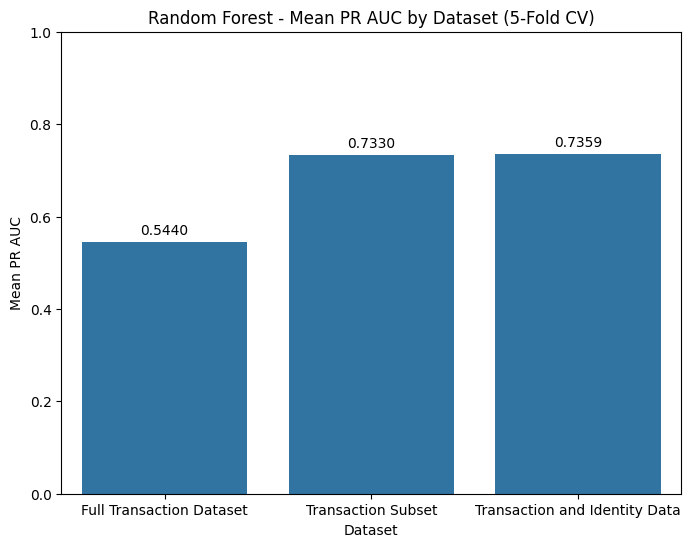

In [32]:

# ### Summary Graphs

# %%
# Calculate mean AUC for each dataset
mean_full = np.mean(cv_transaction['RandomForest_train'])
mean_subset = np.mean(cv_transaction_subset['RandomForest_train'])
mean_combined = np.mean(cv_transaction_combined['RandomForest_train'])

mean_aucs = {
    'Full Transaction Dataset': mean_full,
    'Transaction Subset': mean_subset,
    'Transaction and Identity Data': mean_combined
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(mean_aucs.keys()), y=list(mean_aucs.values()))
plt.title("Random Forest - Mean PR AUC by Dataset (5-Fold CV)")
plt.xlabel("Dataset")
plt.ylabel("Mean PR AUC")

# bar labels
for i, (dataset, mean_auc) in enumerate(mean_aucs.items()):
    plt.text(i, mean_auc + 0.01, f'{mean_auc:.4f}', 
             ha='center', va='bottom')

plt.ylim(0, 1)
plt.show()


In [33]:

# ## Feature Importance Analysis

# %%
def plot_feature_importance(model, feature_names, top_n=20, title="Top Feature Importances"):
    """
    Plot top N most important features from Random Forest
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 8))
    plt.title(f"{title} (Top {top_n})")
    plt.barh(range(top_n), importances[indices[:top_n]][::-1])
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    return indices[:top_n]


Full Transaction Data - Top Features:


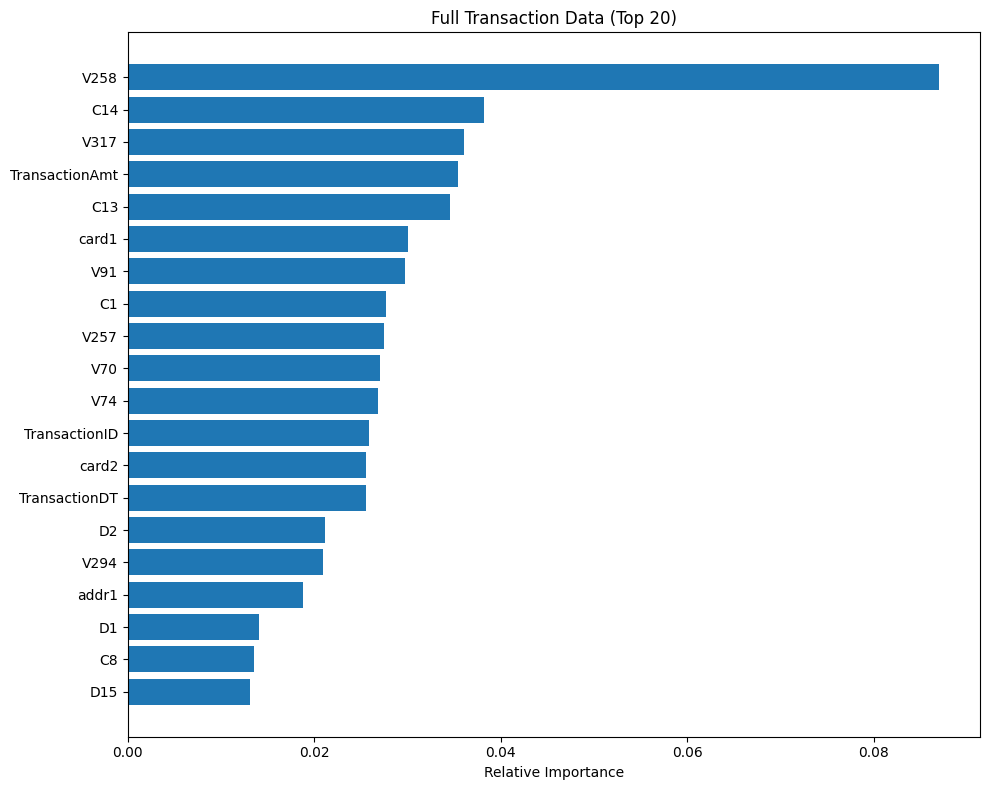

Transaction Subset - Top Features:


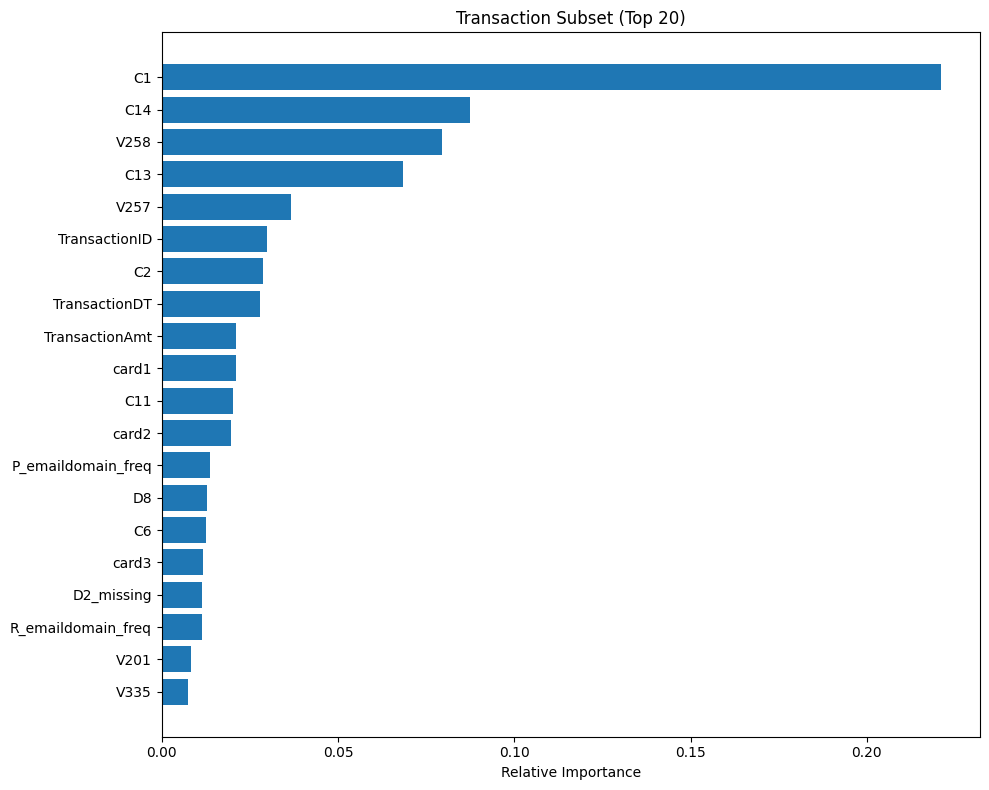

Combined Data - Top Features:


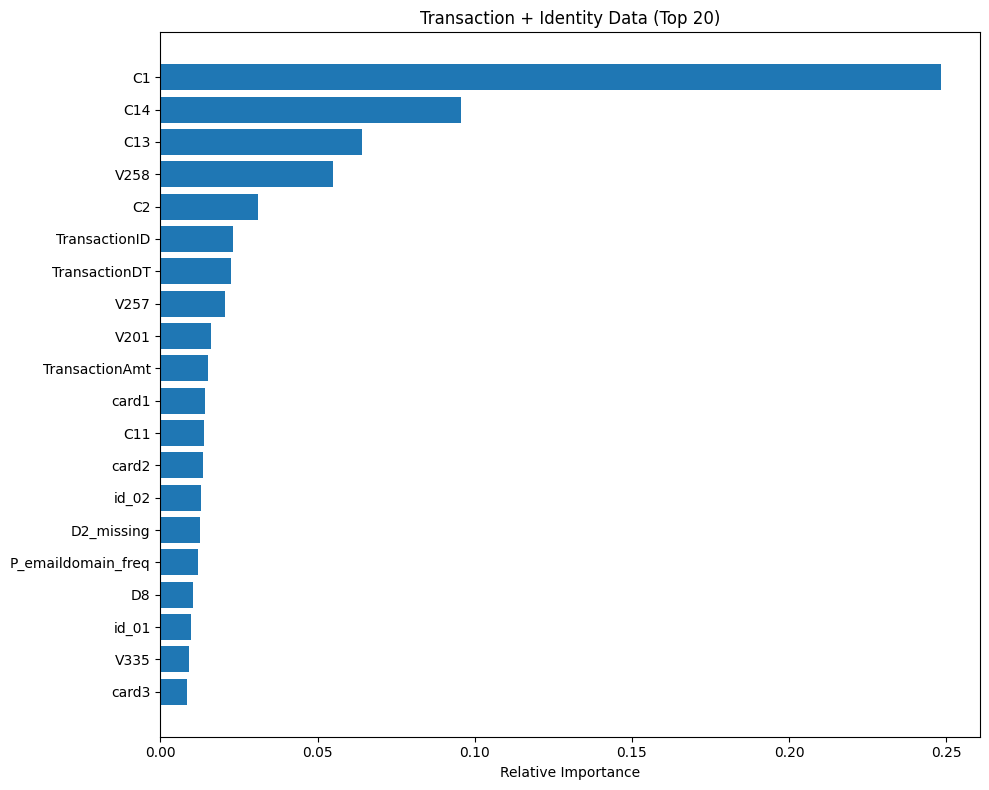

In [34]:

# Plot feature importance for each model
print("Full Transaction Data - Top Features:")
top_full = plot_feature_importance(model_full, X_train.columns, title="Full Transaction Data")

print("Transaction Subset - Top Features:")
top_subset = plot_feature_importance(model_subset, X_train_s.columns, title="Transaction Subset")

print("Combined Data - Top Features:")
top_combined = plot_feature_importance(model_combined, X_train_c.columns, title="Transaction + Identity Data")


Random Forest Performance Summary:
                  Dataset  Single_Split_AUC  CV_Mean_AUC  CV_Std_AUC
0        Full Transaction          0.672082     0.544020    0.010233
1      Transaction Subset          0.823814     0.732976    0.013462
2  Transaction + Identity          0.830683     0.735934    0.016497


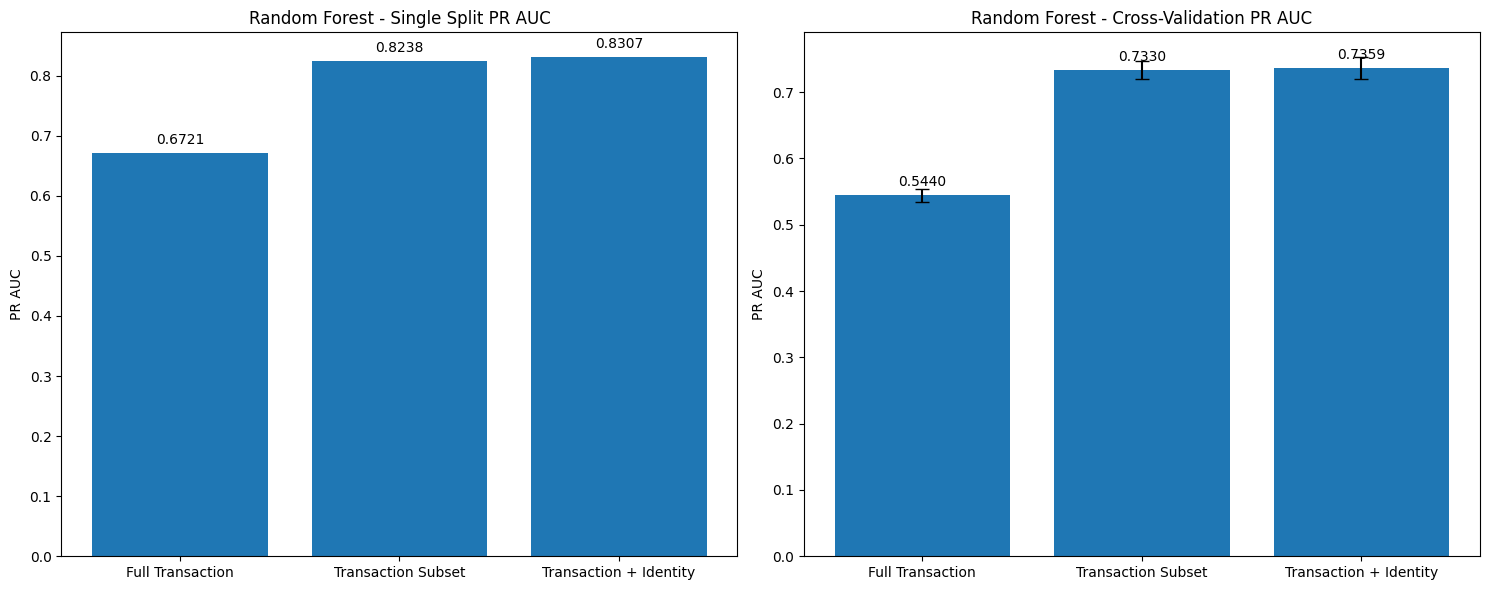

In [35]:

# ## Performance Comparison Summary

# %%
# Create comparison table
comparison_data = {
    'Dataset': ['Full Transaction', 'Transaction Subset', 'Transaction + Identity'],
    'Single_Split_AUC': [rf_transaction, rf_transaction_subset, rf_transaction_combined],
    'CV_Mean_AUC': [mean_full, mean_subset, mean_combined],
    'CV_Std_AUC': [
        np.std(cv_transaction['RandomForest_train']),
        np.std(cv_transaction_subset['RandomForest_train']),
        np.std(cv_transaction_combined['RandomForest_train'])
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Random Forest Performance Summary:")
print(comparison_df)

# Plot final comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Single split comparison
ax1.bar(comparison_df['Dataset'], comparison_df['Single_Split_AUC'])
ax1.set_title('Random Forest - Single Split PR AUC')
ax1.set_ylabel('PR AUC')
for i, v in enumerate(comparison_df['Single_Split_AUC']):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# CV comparison with error bars
ax2.bar(comparison_df['Dataset'], comparison_df['CV_Mean_AUC'], 
        yerr=comparison_df['CV_Std_AUC'], capsize=5)
ax2.set_title('Random Forest - Cross-Validation PR AUC')
ax2.set_ylabel('PR AUC')
for i, v in enumerate(comparison_df['CV_Mean_AUC']):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Data for XGBoost

In [ ]:
'''
identity_xgb = identity_data.copy()
transaction_xgb = transaction_data.copy()

cat_cols = transaction_xgb.select_dtypes(include=["object"]).columns
num_cols = transaction_xgb.select_dtypes(exclude=["object"]).columns
# one-hot encode
xgb_transaction_df = pd.get_dummies(transaction_xgb, columns=cat_cols, drop_first=True)

cat_cols = identity_xgb.select_dtypes(include=["object"]).columns
num_cols = identity_xgb.select_dtypes(exclude=["object"]).columns
# one-hot encode
xgb_identity_df = pd.get_dummies(identity_xgb, columns=cat_cols, drop_first=True)
xgb_transaction_df
xgb_identity_df

'''

## Data for CatBoost and Light GBM

## EDA

### Class Imbalance

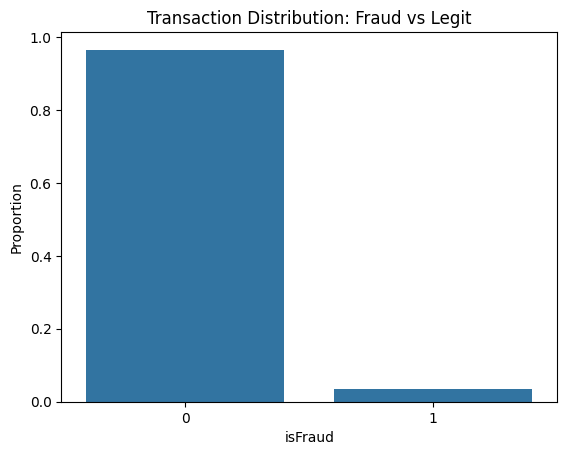

In [ ]:
### EDA
# fraud vs legit
fraud_counts = transaction['isFraud'].value_counts(normalize=True)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Transaction Distribution: Fraud vs Legit")
plt.xlabel("isFraud")
plt.ylabel("Proportion")
plt.show()

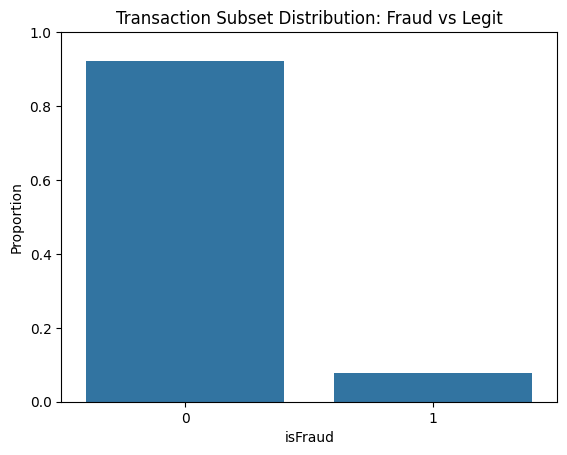

In [ ]:
fraud_counts = merged_df['isFraud'].value_counts(normalize=True)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Transaction Subset Distribution: Fraud vs Legit")
plt.xlabel("isFraud")
plt.ylabel("Proportion")
plt.ylim(0,1)
plt.show()

### Column Analysis

In [ ]:
def analyze_unknown_columns(df):
    """
    column analysis function translated from R
    """
    analysis_data = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        col_type = col_data.dtype
        na_percent = round(col_data.isna().mean() * 100, 2)
        unique_values = col_data.nunique()
        
        # Min/Max for numeric columns
        if np.issubdtype(col_type, np.number):
            if col_data.notna().any():
                min_val = round(col_data.min(), 2)
                max_val = round(col_data.max(), 2)
            else:
                min_val = "All NA"
                max_val = "All NA"
        else:
            min_val = "N/A"
            max_val = "N/A"
        
        # Sample values (first 5 non-null unique values)
        sample_vals = col_data.dropna().unique()[:5]
        sample_str = ", ".join(str(x) for x in sample_vals)
        
        analysis_data.append({
            'column': col,
            'type': col_type,
            'na_percent': na_percent,
            'unique_values': unique_values,
            'min_value': min_val,
            'max_value': max_val,
            'sample_values': sample_str
        })
    
    # Create analysis DataFrame
    column_analysis = pd.DataFrame(analysis_data)
    
    print("=== AUTOMATED COLUMN ANALYSIS ===")
    pd.set_option('display.max_rows', None)
    print(column_analysis)
    pd.reset_option('display.max_rows')
    
    return column_analysis

#### Transaction

In [ ]:
column_info = analyze_unknown_columns(transaction)

=== AUTOMATED COLUMN ANALYSIS ===
             column     type  na_percent  unique_values min_value  max_value  \
0     TransactionID    int64        0.00         590540   2987000    3577539   
1           isFraud    int64        0.00              2         0          1   
2     TransactionDT    int64        0.00         573349     86400   15811131   
3    TransactionAmt  float64        0.00          20902      0.25   31937.39   
4         ProductCD   object        0.00              5       N/A        N/A   
5             card1    int64        0.00          13553      1000      18396   
6             card2  float64        1.51            500     100.0      600.0   
7             card3  float64        0.27            114     100.0      231.0   
8             card4   object        0.27              4       N/A        N/A   
9             card5  float64        0.72            119     100.0      237.0   
10            card6   object        0.27              4       N/A        N/A   
11    

#### Identity

In [ ]:
column_info = analyze_unknown_columns(identity)

=== AUTOMATED COLUMN ANALYSIS ===
           column     type  na_percent  unique_values min_value max_value  \
0   TransactionID    int64        0.00         144233   2987004   3577534   
1           id_01  float64        0.00             77    -100.0       0.0   
2           id_02  float64        2.33         115655       1.0  999595.0   
3           id_03  float64       54.02             24     -13.0      10.0   
4           id_04  float64       54.02             15     -28.0       0.0   
5           id_05  float64        5.11             93     -72.0      52.0   
6           id_06  float64        5.11            101    -100.0       0.0   
7           id_07  float64       96.43             84     -46.0      61.0   
8           id_08  float64       96.43             94    -100.0       0.0   
9           id_09  float64       48.05             46     -36.0      25.0   
10          id_10  float64       48.05             62    -100.0       0.0   
11          id_11  float64        2.26    